<a href="https://www.kaggle.com/code/jasminemohamed2545/a-plant-disease-classifier-vgg-resnet50-97-acc?scriptVersionId=256789629" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import kagglehub
rashikrahmanpritom_plant_disease_recognition_dataset_path = kagglehub.dataset_download('rashikrahmanpritom/plant-disease-recognition-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
import pandas as pd
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import *

2025-08-19 10:01:53.483049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755597713.634654      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755597713.679147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = rashikrahmanpritom_plant_disease_recognition_dataset_path

for item in os.listdir(path):
    print(item)
    print("Is folder:", os.path.isdir(os.path.join(path, item)))

Validation
Is folder: True
Test
Is folder: True
Train
Is folder: True


In [4]:
def loadingData(DSpath, imagesize =(224, 224)):
    imgs, lbls = [], []
    for cls in sorted(os.listdir(DSpath)):
        clspath = os.path.join(DSpath, cls)
        if not os.path.isdir(clspath): continue
        for imgnm in os.listdir(clspath):
            img = cv2.imread(os.path.join(clspath,imgnm))
            if img is not None:
                imgs.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imagesize))
                lbls.append(cls)

    return np.array(imgs), np.array(lbls)


# Loading Data to a train path, validation path, test path

In [5]:
base = rashikrahmanpritom_plant_disease_recognition_dataset_path
trainpth, valpth, testpth = [os.path.join(base, x) for x in ['Train/Train', 'Validation/Validation', 'Test/Test']]

# EDA

In [6]:
# How many files found in each path
def count_images_in_folder(folder_path):
    total = 0
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        total += len(os.listdir(class_folder))
    return total

train_count = count_images_in_folder(trainpth)
val_count = count_images_in_folder(valpth)
test_count = count_images_in_folder(testpth)

print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Train images: 1322
Validation images: 60
Test images: 150


In [7]:
# How many classes in the train path
for class_name in os.listdir(trainpth):
    class_folder = os.path.join(trainpth, class_name)
    files = os.listdir(class_folder)
    print(f"{class_name}: {len(files)} images")

Healthy: 458 images
Rust: 434 images
Powdery: 430 images


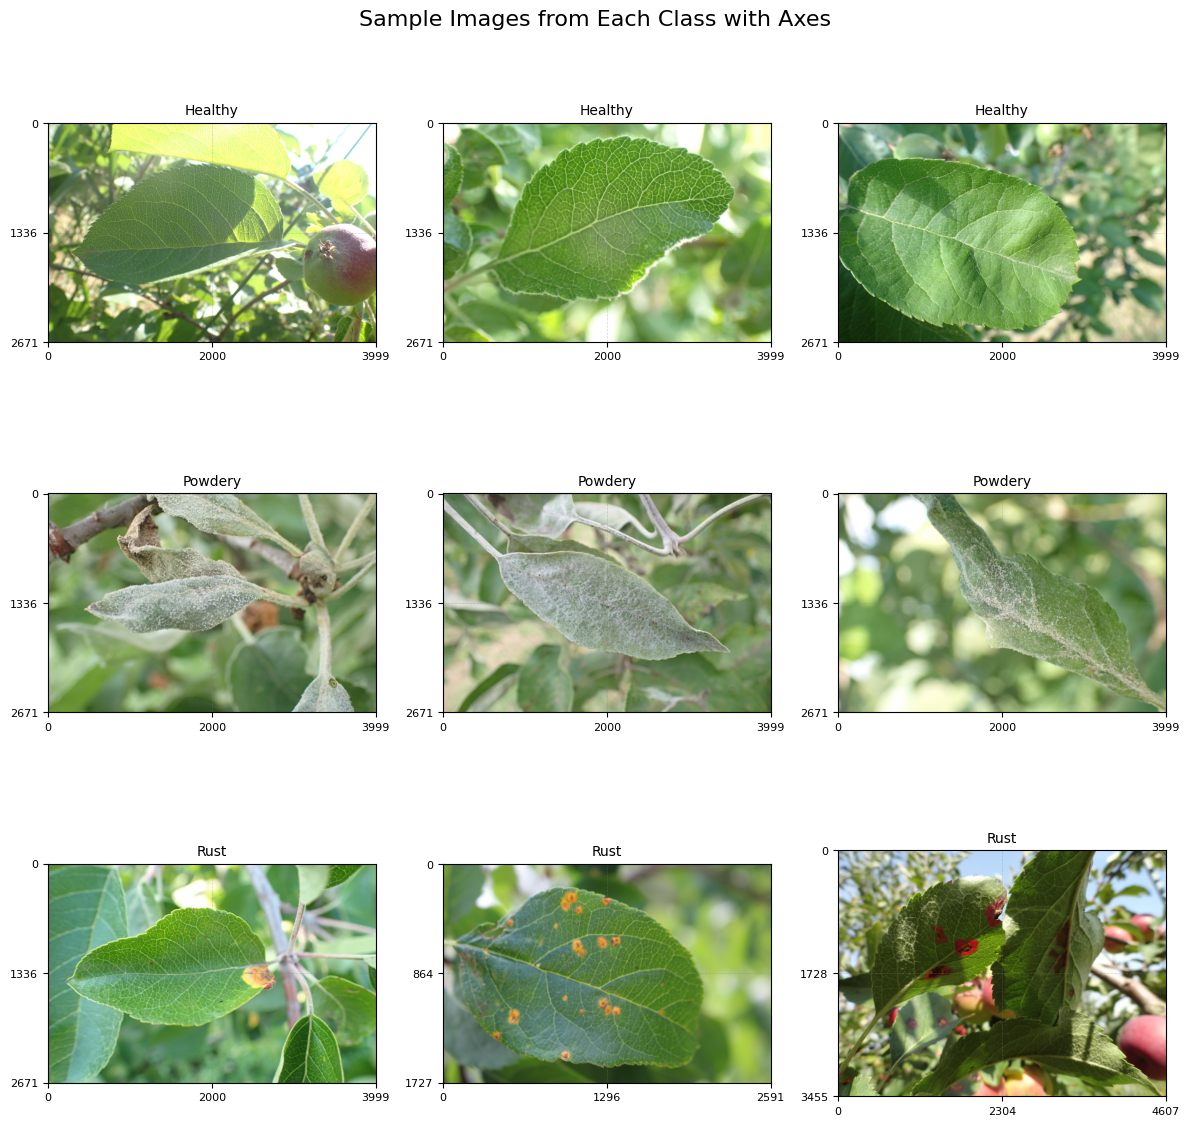

In [8]:
import cv2
import os
import matplotlib.pyplot as plt

def show_sample_images_with_axes(data_path, classes, image_per_class=2):
    fig, axs = plt.subplots(len(classes), image_per_class, figsize=(image_per_class * 4, len(classes) * 4))

    if len(classes) == 1:
        axs = [axs]  # handle when there is only one class
    elif image_per_class == 1:
        axs = [[ax] for ax in axs]  # handle 1 column

    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        images = os.listdir(class_folder)[:image_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            ax = axs[i][j]
            ax.imshow(img)
            ax.set_title(f"{class_name}", fontsize=10)
            ax.set_xticks([0, img.shape[1]//2, img.shape[1]-1])
            ax.set_yticks([0, img.shape[0]//2, img.shape[0]-1])
            ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=8)

    plt.suptitle("Sample Images from Each Class with Axes", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images_with_axes(trainpth, ['Healthy', 'Powdery', 'Rust'], image_per_class=3)

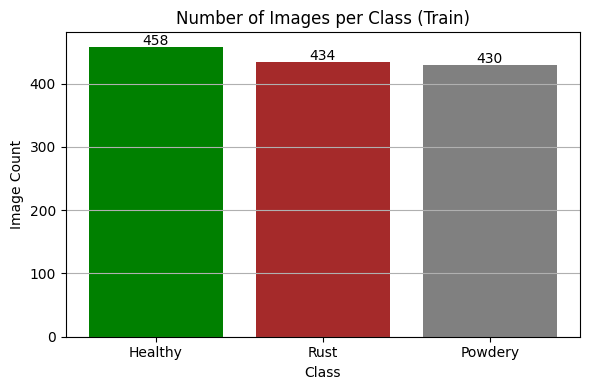

In [9]:
# Visualizing classes imbalances
import os
import matplotlib.pyplot as plt
import numpy as np

class_counts = {}
for class_name in os.listdir(trainpth):
    class_folder = os.path.join(trainpth, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(6,4))
plt.bar(classes, counts, color=['green', 'brown', 'grey'])
plt.title('Number of Images per Class (Train)')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.grid(axis='y')

for i in range(len(classes)):
    plt.text(i, counts[i] + 3, str(counts[i]), ha='center')

plt.tight_layout()
plt.show()

# Splitting data found in each path to features(x) and target(y)

In [10]:
x_train_origin, y_train = loadingData(trainpth)
x_val_origin, y_val = loadingData(valpth)
x_test_origin, y_test = loadingData(testpth)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [11]:
num_classes = len(np.unique(y_train_encoded))
print(f"You have {num_classes} unique classes in your data.")

You have 3 unique classes in your data.


In [12]:
print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes mapping: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


# Preprocessing

In [13]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

def DataGenerator(model='CNN'):
    if model == 'CNN':
        preprocessing = None
        rescale = 1.0 / 255.0
    elif model == 'VGG':
        preprocessing = vgg_preprocess
        rescale = None
    elif model == 'ResNet50':
        preprocessing = resnet_preprocess
        rescale = None
    else:
        raise ValueError("Invalid model name")

    datagen = ImageDataGenerator(
        rotation_range=20,
        validation_split=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=rescale,
        preprocessing_function=preprocessing
    )

    return datagen

# Custom CNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Define your model
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  # Replace `num_classes` with your actual number
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755597836.830332      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755597836.830940      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
from tensorflow.keras.optimizers import SGD
optimizerSGD = SGD(learning_rate=0.0001, momentum=0.9,nesterov=True)

In [16]:
model_CNN.compile(
    optimizer=optimizerSGD,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#reduce_lr = ReduceLROnPlateau(
#    monitor='val_loss',
#    factor=0.5,
#    patience=3,
#    verbose=1,
#    min_lr=1e-4
#)

# ===============================================================
# 🔍 LESSON LEARNED: Accuracy was stuck around 33% — THE WHY?
# ---------------------------------------------------------------
# After a lot of debugging, it turned out the issue was NOT data quality,
# NOT model architecture, NOT augmentation... It was the LEARNING RATE! 😱
#
# ✅ If the learning rate is TOO HIGH:
#    ➤ The model keeps "jumping around" and fails to learn.
#
# ✅ If it's TOO LOW:
#    ➤ The model barely updates, and training stays flat.
#
# ✅ In my case: Lowering the learning rate (e.g. from 0.001 → 0.0001)
#    made the model start learning properly and improve accuracy! 🎯
# ===============================================================

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_cnn_train = DataGenerator(model='CNN')
train_generator = datagen_cnn_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)

datagen_cnn_val = DataGenerator(model='CNN')
val_generator = datagen_cnn_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [19]:
history = model_CNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1755597843.360329      67 service.cc:148] XLA service 0x79e1d40098f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755597843.361472      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755597843.361494      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755597843.661322      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/21 ━━━━━━━━━━━━━━━━━━━━ 4:11 13s/step - accuracy: 0.4219 - loss: 1.8338

I0000 00:00:1755597852.372525      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4791 - loss: 1.6571 - val_accuracy: 0.3333 - val_loss: 1.1265
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 665ms/step - accuracy: 0.7112 - loss: 0.8280 - val_accuracy: 0.3333 - val_loss: 1.3515
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 661ms/step - accuracy: 0.7731 - loss: 0.6776 - val_accuracy: 0.3333 - val_loss: 1.7171
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 668ms/step - accuracy: 0.7951 - loss: 0.5757 - val_accuracy: 0.3333 - val_loss: 2.2405
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 667ms/step - accuracy: 0.8035 - loss: 0.5318 - val_accuracy: 0.3333 - val_loss: 2.9462
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 673ms/step - accuracy: 0.8108 - loss: 0.4691 - val_accuracy: 0.3333 - val_loss: 3.5014


In [20]:
model_CNN.save('best_cnn_model.h5')

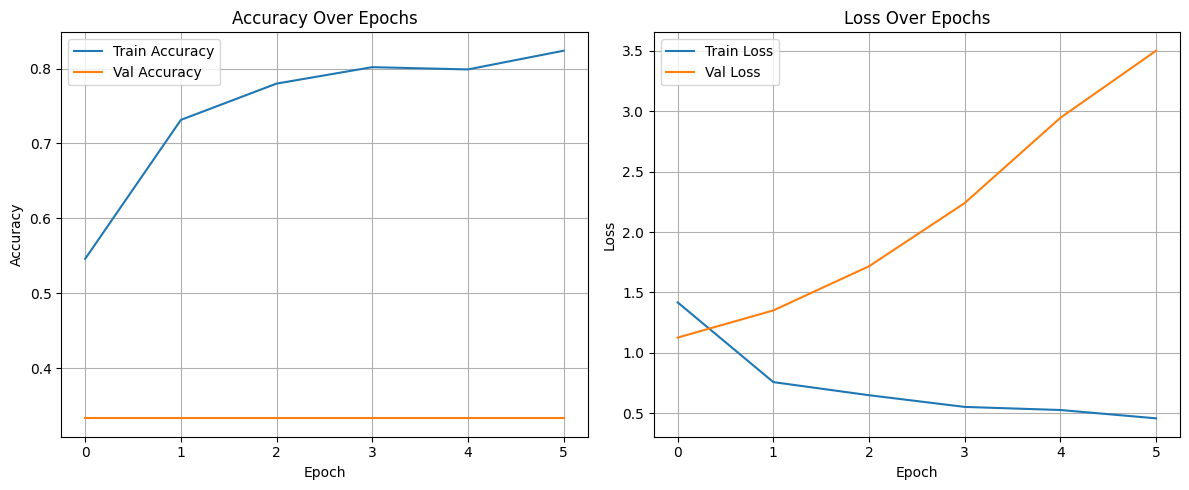

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [22]:
datagen_CNN_test = DataGenerator(model='CNN')
test_generator_CNN = datagen_CNN_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs_CNN = model_CNN.predict(test_generator_CNN)
y_pred_CNN = np.argmax(y_pred_probs_CNN, axis=1)
y_true = y_test_encoded

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step


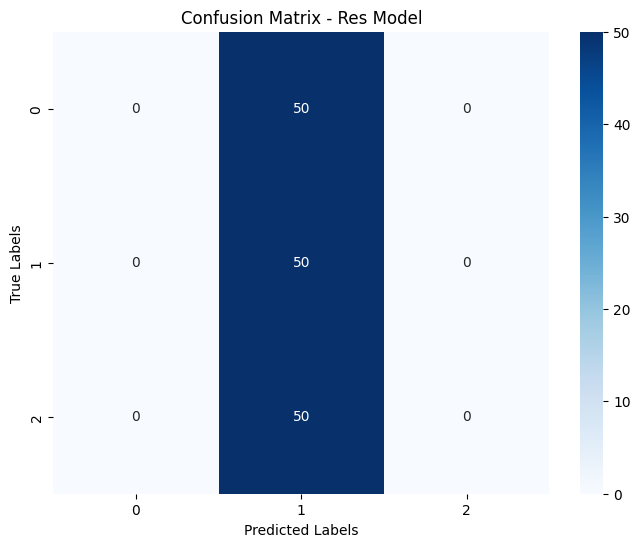

              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00        50
     class_1       0.33      1.00      0.50        50
     class_2       0.00      0.00      0.00        50

    accuracy                           0.33       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.11      0.33      0.17       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_CNN)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Res Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']
report = classification_report(y_true, y_pred_CNN, target_names=class_names)
print(report)

# The CNN is a real loser here

# VGG Model

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:10]:
    layer.trainable = False

for layer in base_model.layers[10:]:
    layer.trainable = True
model_VGG = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model_VGG.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
callbacky =[
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

In [27]:
datagen_vgg_train = DataGenerator(model='VGG')
train_generator_vgg = datagen_vgg_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)

datagen_vgg_val = DataGenerator(model='VGG')
val_generator_vgg = datagen_vgg_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [28]:
#callbacky =[
#    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#    ModelCheckpoint('best_model.h5', save_best_only=True)
#]

In [29]:
history = model_VGG.fit(
  train_generator_vgg,
  validation_data=val_generator_vgg,
  epochs=30,
  #callbacks=callbacky,
  batch_size=64
  )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 1/21 ━━━━━━━━━━━━━━━━━━━━ 9:29 28s/step - accuracy: 0.2857 - loss: 1.9037

2025-08-19 10:06:29.200339: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-19 10:06:29.429559: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.229325797s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

21/21 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.4209 - loss: 1.3382 - val_accuracy: 0.3333 - val_loss: 22.0586
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 729ms/step - accuracy: 0.4784 - loss: 1.1329 - val_accuracy: 0.3333 - val_loss: 3.8482
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 697ms/step - accuracy: 0.5196 - loss: 0.9983 - val_accuracy: 0.3333 - val_loss: 7.8286
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 694ms/step - accuracy: 0.7790 - loss: 0.5739 - val_accuracy: 0.6667 - val_loss: 3.2210
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 760ms/step - accuracy: 0.9165 - loss: 0.2605 - val_accuracy: 0.6000 - val_loss: 2.1872
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - accuracy: 0.9530 - loss: 0.1393 - val_accuracy: 0.6500 - val_loss: 1.4707
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 741ms/step - accuracy: 0.9757 - loss: 0.1002 - val_accuracy: 0.6000 - val_loss: 2.4619
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 729ms/step - accuracy: 0.9828 - loss: 0.0729 - val_accuracy: 0.6000

In [30]:
import numpy as np

# Save history for later use
np.save('vgg_history.npy', history.history)

In [31]:
model_VGG.save('vgg_model_full.h5')

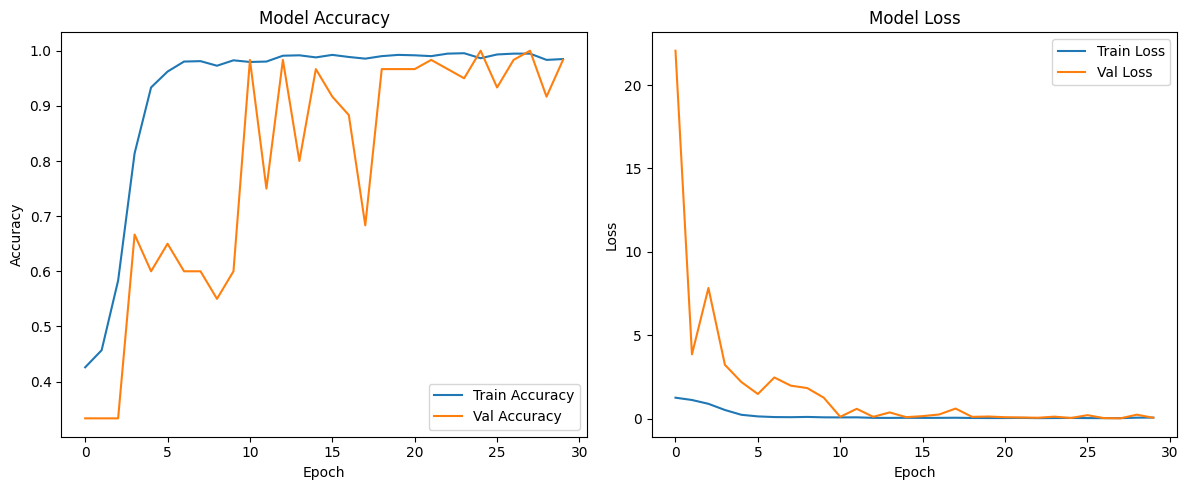

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
datagen_vgg_test = DataGenerator(model='VGG')
test_generator_vgg = datagen_vgg_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs = model_VGG.predict(test_generator_vgg)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_encoded

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step


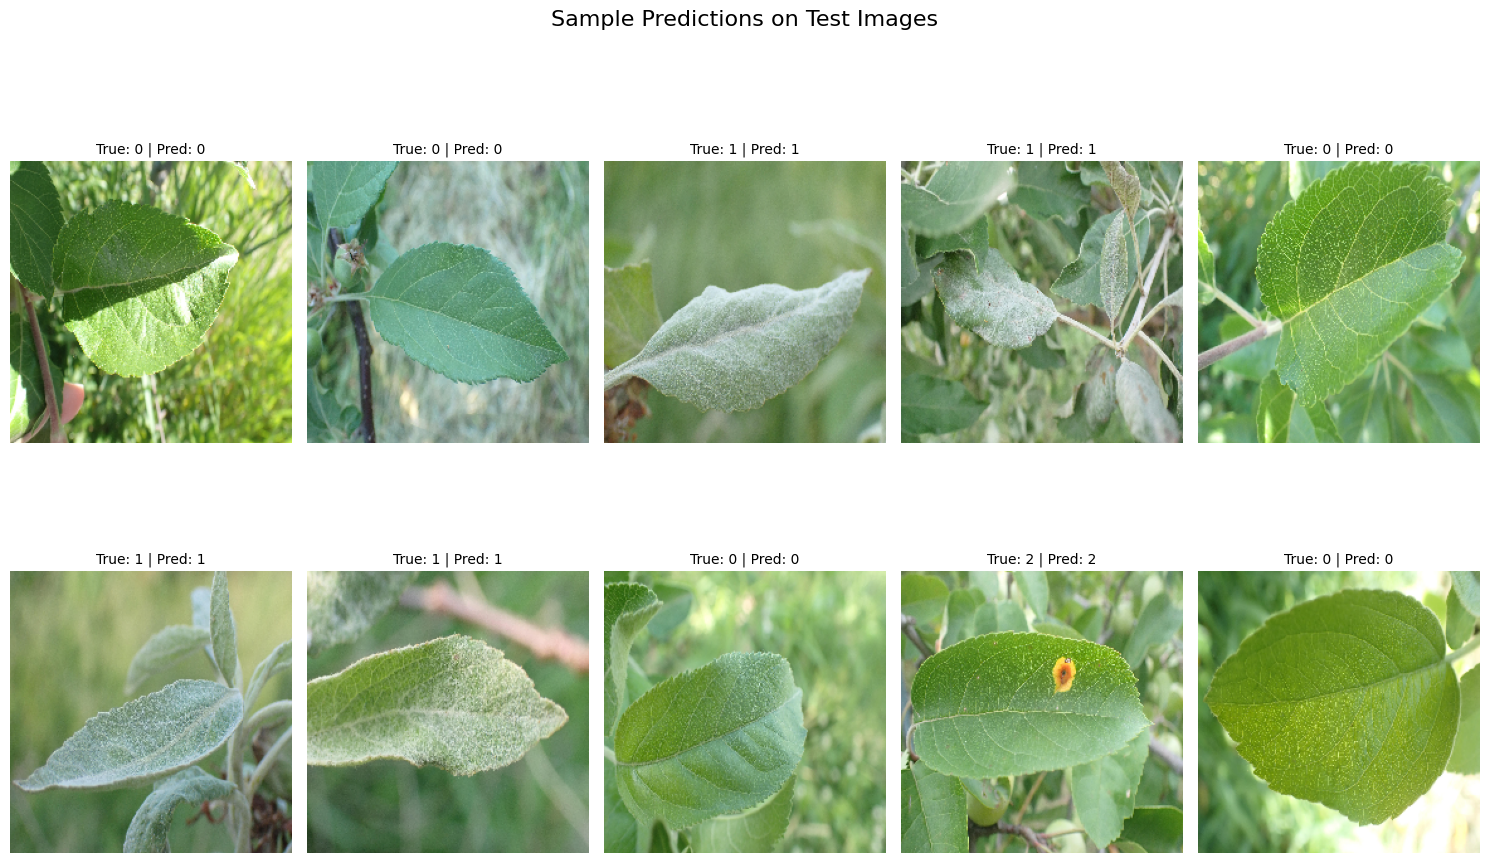

In [34]:
num_samples = 10

indices = np.random.choice(len(x_test_origin), num_samples, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img = x_test_origin[idx]
    true_label = y_test_encoded[idx]
    pred_label = y_pred[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    true_name = le.inverse_transform([true_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]
    plt.title(f"True: {true_name} | Pred: {pred_name}", fontsize=10)
    plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=10)

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
y_true = y_test_encoded

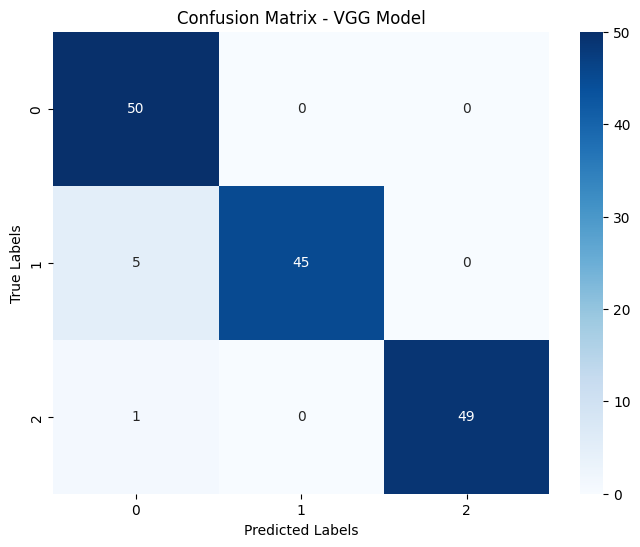

              precision    recall  f1-score   support

     class_0       0.89      1.00      0.94        50
     class_1       1.00      0.90      0.95        50
     class_2       1.00      0.98      0.99        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - VGG Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']  # ← غيريها حسب أسماء الكلاسات عندك
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# ResNet50

In [37]:
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_res.layers[:100]:
    layer.trainable = False
for layer in base_model_res.layers[100:]:
    layer.trainable = True


model_RES = Sequential([
    base_model_res,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
from tensorflow.keras.optimizers import SGD

optimizer_res = SGD(learning_rate=0.01, momentum=0.9)

model_RES.compile(
    optimizer=optimizer_res,
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [39]:
callbacky_res = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
]

In [40]:
datagen_res_train = DataGenerator(model='ResNet50')
train_generator_res = datagen_res_train.flow(x_train_origin, y_train_encoded, batch_size=16, shuffle=True)

datagen_res_val = DataGenerator(model='ResNet50')
val_generator_res = datagen_res_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [41]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [42]:
history_res = model_RES.fit(
    train_generator_res,
    validation_data=val_generator_res,
    epochs=10,
    callbacks=callbacky_res
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 641ms/step - accuracy: 0.8412 - loss: 0.4400 - val_accuracy: 0.8333 - val_loss: 0.6343
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 611ms/step - accuracy: 0.9645 - loss: 0.1429 - val_accuracy: 0.9333 - val_loss: 0.0914
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 612ms/step - accuracy: 0.9679 - loss: 0.1141 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 598ms/step - accuracy: 0.9861 - loss: 0.0434 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 609ms/step - accuracy: 0.9852 - loss: 0.0489 - val_accuracy: 1.0000 - val_loss: 9.9746e-04
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 602ms/step - accuracy: 0.9911 - loss: 0.0228 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 599ms/step - accuracy: 0.9895 - loss: 0.0502 - val_accuracy: 0.9667 - val_loss: 0.0388
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 601ms/step - accuracy: 0.9904 - loss: 0.0421 - val_accuracy: 1

In [43]:
import numpy as np
np.save('resnet_history.npy', history_res.history)

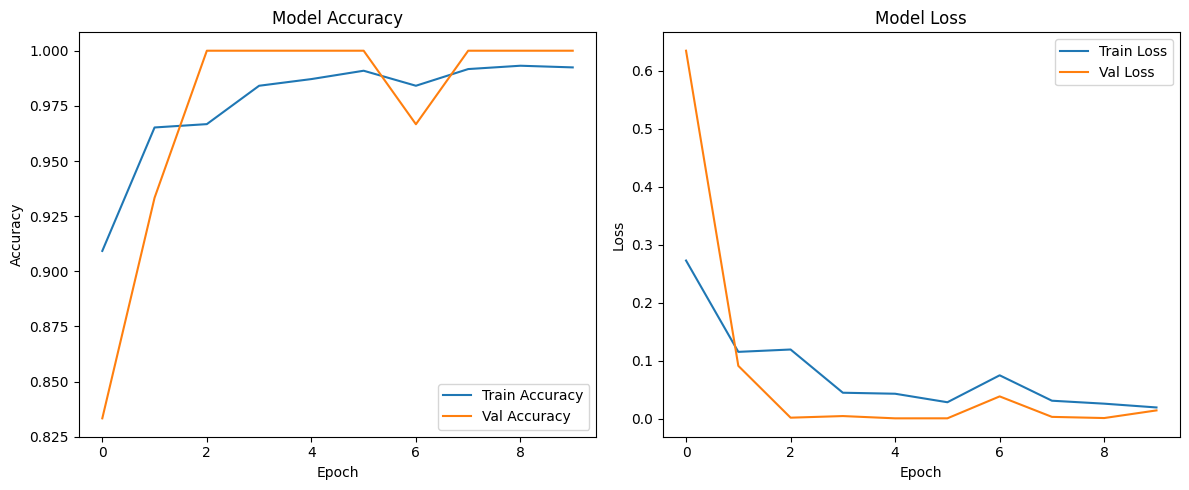

In [44]:
import matplotlib.pyplot as plt

history_dict = history_res.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
y_pred_probs_Res= model_RES.predict(x_train_origin)
y_pred_Res = np.argmax(y_pred_probs_Res, axis=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step


In [46]:
datagen_Res_test = DataGenerator(model='ResNet50')
test_generator_Res = datagen_Res_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs_Res = model_RES.predict(test_generator_Res)
y_pred_Res = np.argmax(y_pred_probs_Res, axis=1)
y_true = y_test_encoded

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step


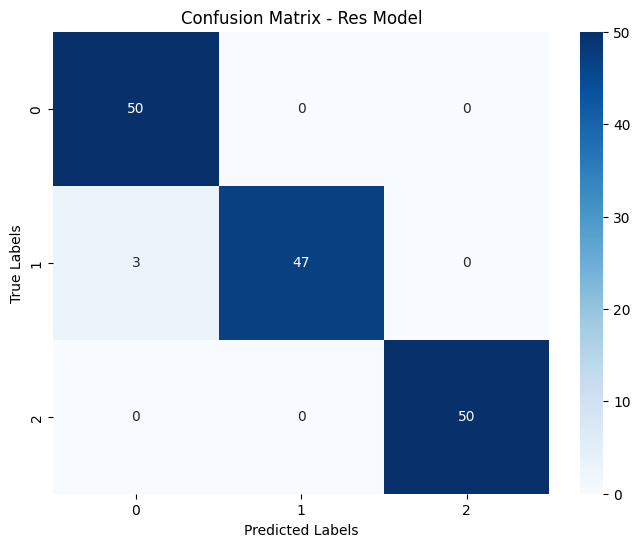

              precision    recall  f1-score   support

     class_0       0.89      1.00      0.94        50
     class_1       1.00      0.90      0.95        50
     class_2       1.00      0.98      0.99        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_Res)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Res Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

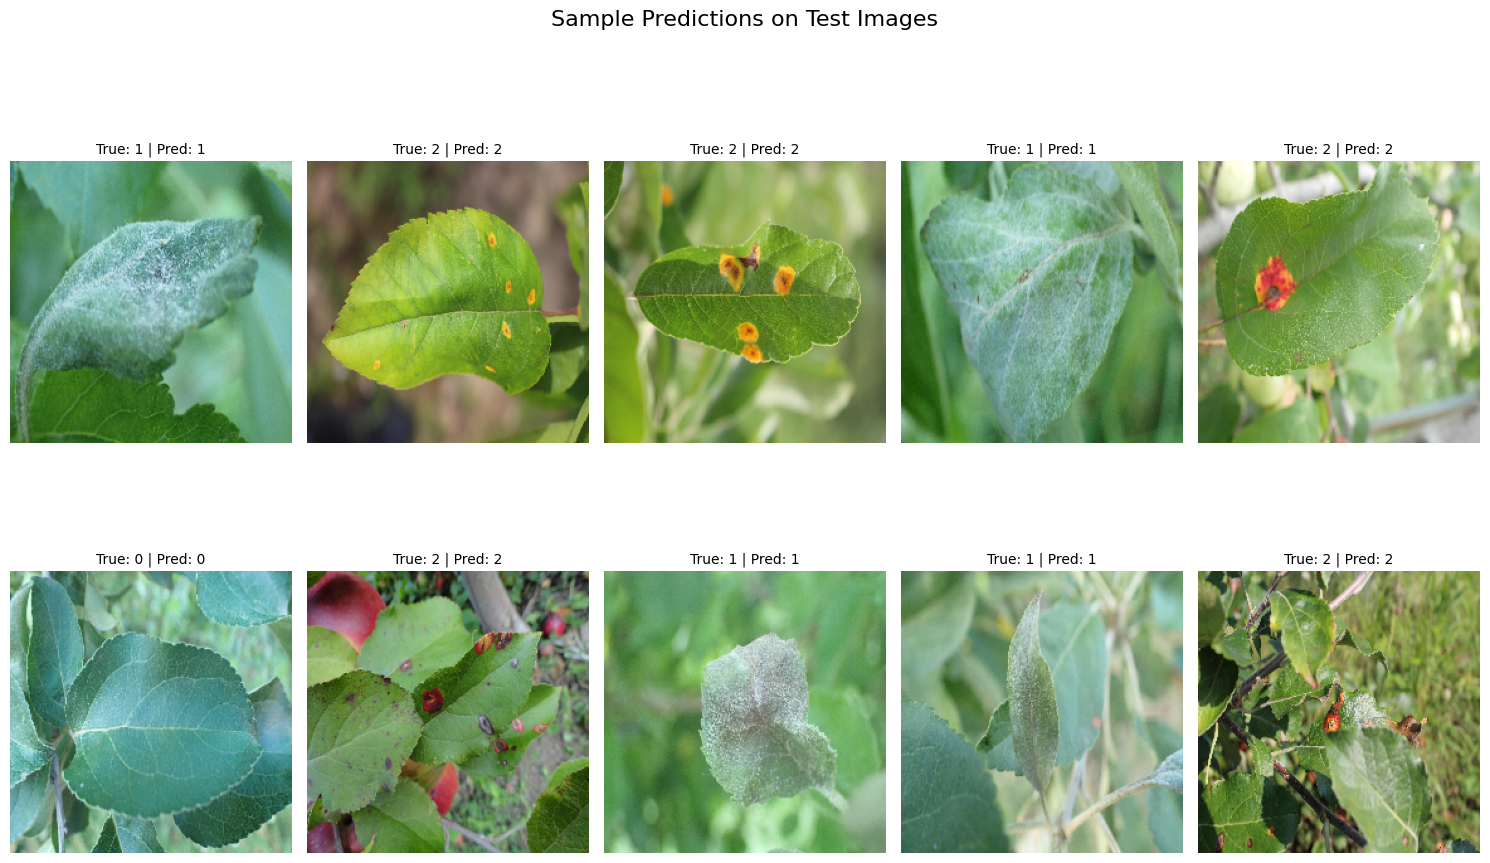

In [48]:
num_samples = 10

indices = np.random.choice(len(x_test_origin), num_samples, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img = x_test_origin[idx]
    true_label = y_test_encoded[idx]
    pred_label = y_pred_Res[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    true_name = le.inverse_transform([true_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]
    plt.title(f"True: {true_name} | Pred: {pred_name}", fontsize=10)
    plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=10)

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()

# ResNet is the best! Yayyyy ❤